In [1]:
import os
import sys
sys.path.append('/home/lucajn/connect/source/profile_likelihoods')
sys.path.append('/home/lucajn/connect/resources/montepython_public')
import numpy as np
import warnings
import scipy.constants as conts
import tensorflow as tf
import pickle as pkl
import matplotlib.pyplot as plt
import pandas as pd
import time
from matplotlib.ticker import FuncFormatter
from new_Spline import Spline_tri
from classy import Class

2023-12-17 14:53:44.699202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-17 14:53:44.869983: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-17 14:53:44.876102: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /comm/swstack/core/anaconda3/2021.05/lib
2023-12-17 14:53:44.876116: I tensorflow/stream_executo

TF_BAO CLASS

In [2]:
class TF_bao():

    # Initialization routine
    def __init__(self, model_name):

        # Load CONNECT model
        self.model = tf.keras.models.load_model(model_name, compile=False)
        self.output_info = eval(self.model.get_raw_info().numpy().decode('utf-8'))

        # Set path to datafile (Hardcoded paths would be avoided for general implementation)
        self.data_directory = '/home/lucajn/connect/resources/montepython_public/data/'
        self.file = 'bao_2012.txt'
        self.rs_rescale = 153.017 / 149.0808 # From tf_bao.data file

        # Define emulated data
        self.all_z = np.array(self.output_info['z_bg'])
        self.ang_idx = self.output_info['interval']['bg']['ang.diam.dist.'][:2]
        self.hubble_idx = self.output_info['interval']['bg']['H [1/Mpc]'][:2]
        self.rs_drag_idx = self.output_info['interval']['extra']['rs_drag'][0]

        # Define array for values of z and data points
        self.z = np.array([], 'float64')
        self.data = np.array([], 'float64')
        self.error = np.array([], 'float64')
        self.type = np.array([], 'int')

        # Read redshifts and data points
        for line in open(os.path.join(self.data_directory, self.file), 'r'):
            if (line.find('#') == -1):
                self.z = np.append(self.z, float(line.split()[0]))
                self.data = np.append(self.data, float(line.split()[1]))
                self.error = np.append(self.error, float(line.split()[2]))
                self.type = np.append(self.type, int(line.split()[3]))

        # Spline
        if set(self.all_z).intersection(self.z) != set(self.z):
            S = Spline_tri(tf.constant(self.all_z, dtype=tf.float32), tf.constant(self.z, dtype=tf.float32))
            self.spline = lambda x: S.do_spline(x)
        else:
            self.indices = np.searchsorted(self.all_z, self.z)
            self.spline = lambda x: tf.gather(x, self.indices, axis=1)

    @tf.function
    def loglkl(self, x):
        
        # Define output
        output = self.model(x[:,:])

        # Calculations
        hubble = self.spline(output[:, self.hubble_idx[0]:self.hubble_idx[1]])
        da = self.spline(output[:, self.ang_idx[0]:self.ang_idx[1]])
        dr = tf.divide(self.z, hubble)
        dv = tf.pow(da * da * (1 + self.z) * (1 + self.z) * dr, 1. / 3.)
        rs_drag = output[:,self.rs_drag_idx:self.rs_drag_idx+1]

        # Initialize a tensor for the 'theo' values
        theo = tf.zeros_like(self.z, dtype=tf.float32)
        
        # Handle the different types using boolean masks
        mask_type3 = tf.math.equal(self.type, 3)
        rs = rs_drag * self.rs_rescale
        theo = tf.where(mask_type3, dv / rs, theo)
        
        mask_type4 = tf.math.equal(self.type, 4)
        theo = tf.where(mask_type4, dv, theo)

        # Compute chi2
        chi2_values = ((theo - self.data) / self.error) ** 2
        chi2 = tf.reduce_sum(chi2_values, 1, keepdims=True)[:,0]

        # Compute ln(L)
        lkl = -0.5 * chi2
        
        return lkl

TF_BAO_BOSS CLASS

In [3]:
class TF_bao_boss():

    # Initialization routine
    def __init__(self, model_name):

        # Load CONNECT model
        self.model = tf.keras.models.load_model(model_name, compile=False)
        self.output_info = eval(self.model.get_raw_info().numpy().decode('utf-8'))
        
        # Set path to datafile (Hardcoded paths would be avoided for general implementation)
        self.data_directory = '/home/lucajn/connect/resources/montepython_public/data/'
        self.file = 'bao_2014.txt'
        
        # Define emulated data
        self.all_z = np.array(self.output_info['z_bg'])
        self.ang_idx = self.output_info['interval']['bg']['ang.diam.dist.'][:2]
        self.hubble_idx = self.output_info['interval']['bg']['H [1/Mpc]'][:2]
        self.rs_drag_idx = self.output_info['interval']['extra']['rs_drag'][0]
        
        # Define array for values of z and data points
        self.z = np.array([], 'float64')
        self.data = np.array([], 'float64')
        self.error = np.array([], 'float64')
        self.type = np.array([], 'int')

        # Read redshifts and data points
        with open(os.path.join(self.data_directory, self.file), 'r') as filein:
            for line in filein:
                if line.strip() and line.find('#') == -1:
                    # the first entry of the line is the identifier
                    this_line = line.split()
                    # insert into array if this id is not manually excluded
                    if not hasattr(self, 'exclude') or self.exclude == None or not this_line[0] in self.exclude:
                        self.z = np.append(self.z, float(this_line[1]))
                        self.data = np.append(self.data, float(this_line[2]))
                        self.error = np.append(self.error, float(this_line[3]))
                        self.type = np.append(self.type, int(this_line[4]))

        # Spline
        if set(self.all_z).intersection(self.z) != set(self.z):
            S = Spline_tri(tf.constant(self.all_z, dtype=tf.float32), tf.constant(self.z, dtype=tf.float32))
            self.spline = lambda x: S.do_spline(x)
        else:
            self.indices = np.searchsorted(self.all_z, self.z)
            self.spline = lambda x: tf.gather(x, self.indices, axis=1)

    @tf.function
    def loglkl(self, x):

        # Define output
        output = self.model(x[:,:])
        
        # Calculations
        hubble = self.spline(output[:, self.hubble_idx[0]:self.hubble_idx[1]])
        da = self.spline(output[:, self.ang_idx[0]:self.ang_idx[1]])
        dr = tf.divide(self.z, hubble)
        dv = tf.pow(da * da * (1 + self.z) * (1 + self.z) * dr, 1. / 3.)
        rs_drag = output[:,self.rs_drag_idx:self.rs_drag_idx+1]

        # Initialize a tensor for the 'theo' values
        theo = tf.zeros_like(self.z, dtype=tf.float32)

        # Handle the different types using boolean masks and compute theo accordingly

        mask_type3 = tf.math.equal(self.type, 3)
        rs = rs_drag 
        theo = tf.where(mask_type3, dv / rs, theo)

        mask_type4 = tf.math.equal(self.type, 4)
        theo = tf.where(mask_type4, dv, theo)

        mask_type5 = tf.math.equal(self.type, 5)
        theo = tf.where(mask_type5, da / rs, theo)

        mask_type6 = tf.math.equal(self.type, 6)
        theo = tf.where(mask_type6, 1. / hubble / rs, theo)

        mask_type7 = tf.math.equal(self.type, 7)
        theo = tf.where(mask_type7, rs / dv, theo)

        # Compute chi2
        chi2_values = ((theo - self.data) / self.error) ** 2
        chi2 = tf.reduce_sum(chi2_values, 1, keepdims=True)[:,0]

        # Compute ln(L)
        lkl = -0.5 * chi2

        return lkl

TF_BAO_BOSS_DR12 CLASS

In [4]:
class TF_bao_boss_dr12():

    # Initialization routine
    def __init__(self, model_name):

        # Load CONNECT model
        self.model = tf.keras.models.load_model(model_name, compile=False)
        self.output_info = eval(self.model.get_raw_info().numpy().decode('utf-8'))
        self.rs_rescale, self.rd_fid_in_Mpc = 1. , 147.78

        # Define emulated data
        self.all_z = np.array(self.output_info['z_bg'])
        self.ang_idx = self.output_info['interval']['bg']['ang.diam.dist.'][:2]
        self.hubble_idx = self.output_info['interval']['bg']['H [1/Mpc]'][:2]
        self.rs_drag_idx = self.output_info['interval']['extra']['rs_drag'][0]

        # Set path to datafile (Hardcoded paths would be avoided for general implementation)
        self.data_directory = '/home/lucajn/connect/resources/montepython_public/data/COMBINEDDR12_BAO_consensus_dM_Hz/'
        self.data_file = 'BAO_consensus_results_dM_Hz.txt'
        self.cov_file = 'BAO_consensus_covtot_dM_Hz.txt'

        data = np.loadtxt(os.path.join(self.data_directory, self.data_file), skiprows=1, usecols=(0,2))
        self.z = np.array(list(set(data[:,0])))
        self.DM_rdfid_by_rd_in_Mpc, self.H_rd_by_rdfid_in_km_per_s_per_Mpc = np.reshape(data[:,1], [3,2]).T

        # Read covariance matrix
        self.cov_data = np.loadtxt(os.path.join(self.data_directory, self.cov_file))
        self.inv_cov_data = tf.cast(tf.linalg.inv(self.cov_data), tf.float32)

        # Spline
        if set(self.all_z).intersection(self.z) != set(self.z):
            S = Spline_tri(tf.constant(self.all_z, dtype=tf.float32), tf.constant(self.z, dtype=tf.float32))
            self.spline = lambda x: S.do_spline(x)
        else:
            self.indices = np.searchsorted(self.all_z, self.z)
            self.spline = lambda x: tf.gather(x, self.indices, axis=1)

    # compute likelihood
    @tf.function
    def loglkl(self, x):
        # Define output
        output = self.model(x[:,:])
        
        # Compute comoving angular diameter distance D_M = (1 + z) * D_A and Hubble values for each z
        hubble = self.spline(output[:, self.hubble_idx[0]:self.hubble_idx[1]])
        da = self.spline(output[:, self.ang_idx[0]:self.ang_idx[1]])
        DM_at_z_values = da * (1. + self.z)
        H_at_z_values = hubble * conts.c / 1000.0
        rs_drag = output[:,self.rs_drag_idx:self.rs_drag_idx+1]

        # Compute sound horizon at baryon drag rs_d
        rd = rs_drag * self.rs_rescale

        # Compute theoretical predictions
        theo_DM_rdfid_by_rd_in_Mpc = DM_at_z_values / rd * self.rd_fid_in_Mpc
        theo_H_rd_by_rdfid = H_at_z_values * rd / self.rd_fid_in_Mpc

        # Compute differences with observations
        DM_diff = tf.transpose(theo_DM_rdfid_by_rd_in_Mpc - self.DM_rdfid_by_rd_in_Mpc)
        H_diff = tf.transpose(theo_H_rd_by_rdfid - self.H_rd_by_rdfid_in_km_per_s_per_Mpc)

        # Stack DM_diff and H_diff into a single array
        data_array = tf.transpose(tf.dynamic_stitch([[0,2,4],[1,3,5]], [DM_diff, H_diff]))

        # Compute chi squared
        chi2 = tf.reduce_sum(tf.multiply(tf.tensordot(data_array, self.inv_cov_data,1), data_array), 1)
        
        # Return ln(L)
        loglkl = -0.5 * chi2
        
        return loglkl

BAO CLASS

In [5]:
class Bao():

    # initialization routine

    def __init__(self):

        # Set path to datafile (Hardcoded paths would be avoided for general implementation)
        self.data_directory = '/home/lucajn/connect/resources/montepython_public/data/'
        self.file = 'bao_2012.txt'
        self.rs_rescale = 153.017 / 149.0808 # From tf_bao.data file
        
        # define array for values of z and data points
        self.z = np.array([], 'float64')
        self.data = np.array([], 'float64')
        self.error = np.array([], 'float64')
        self.type = np.array([], 'int')

        # read redshifts and data points
        for line in open(os.path.join(
                self.data_directory, self.file), 'r'):
            if (line.find('#') == -1):
                self.z = np.append(self.z, float(line.split()[0]))
                self.data = np.append(self.data, float(line.split()[1]))
                self.error = np.append(self.error, float(line.split()[2]))
                self.type = np.append(self.type, int(line.split()[3]))

        # number of data points
        self.num_points = np.shape(self.z)[0]

        # end of initialization

    # compute likelihood

    def loglkl(self, data):

        chi2 = 0.
        cosmo = Class()
        self.input_names = ['omega_b', 'omega_cdm', 'H0', 'ln10^{10}A_s', 'n_s', 'tau_reio']
        self.params = dict(zip(self.input_names, data))

        # Extra input parameters to CLASS
        extra_input = {
            'k_pivot': 0.05,
            'N_ur': 2.0328,
            'N_ncdm': 1,
            'm_ncdm': 0.06,
            'T_ncdm': 0.71611,
        }

        # Add the extra input to self.params
        self.params.update(extra_input)
        
        cosmo.set(self.params)
        cosmo.compute()
        
        # for each point, compute angular distance da, radial distance dr,
        # volume distance dv, sound horizon at baryon drag rs_d,
        # theoretical prediction and chi2 contribution
        for i in range(self.num_points):

            da = cosmo.angular_distance(self.z[i])
            dr = self.z[i] / cosmo.Hubble(self.z[i])
            dv = pow(da * da * (1 + self.z[i]) * (1 + self.z[i]) * dr, 1. / 3.)

            if (self.type[i] == 3):
                rs = cosmo.rs_drag() * self.rs_rescale
                theo = dv / rs

            elif (self.type[i] == 4):
                theo = dv

            else:
                raise io_mp.LikelihoodError(
                    "In likelihood %s. " % self.name +
                    "BAO data type %s " % self.type[i] +
                    "in %d-th line not understood" % i)

            chi2 += ((theo - self.data[i]) / self.error[i]) ** 2

        # return ln(L)
        lkl = - 0.5 * chi2

        return lkl

BAO_BOSS CLASS

In [6]:
class Bao_boss():

    # initialization routine

    def __init__(self):

        # Set path to datafile (Hardcoded paths would be avoided for general implementation)
        self.data_directory = '/home/lucajn/connect/resources/montepython_public/data/'
        self.file = 'bao_2014.txt'

        # define array for values of z and data points
        self.z = np.array([], 'float64')
        self.data = np.array([], 'float64')
        self.error = np.array([], 'float64')
        self.type = np.array([], 'int')

        # Read redshifts and data points
        with open(os.path.join(self.data_directory, self.file), 'r') as filein:
            for line in filein:
                if line.strip() and line.find('#') == -1:
                    # the first entry of the line is the identifier
                    this_line = line.split()
                    # insert into array if this id is not manually excluded
                    if not hasattr(self, 'exclude') or self.exclude == None or not this_line[0] in self.exclude:
                        self.z = np.append(self.z, float(this_line[1]))
                        self.data = np.append(self.data, float(this_line[2]))
                        self.error = np.append(self.error, float(this_line[3]))
                        self.type = np.append(self.type, int(this_line[4]))

        # number of data points
        self.num_points = np.shape(self.z)[0]

        # end of initialization

    # compute likelihood

    def loglkl(self, data):

        chi2 = 0.
        cosmo = Class()
        self.input_names = ['omega_b', 'omega_cdm', 'H0', 'ln10^{10}A_s', 'n_s', 'tau_reio']
        self.params = dict(zip(self.input_names, data))

        # Extra input parameters to CLASS
        extra_input = {
            'k_pivot': 0.05,
            'N_ur': 2.0328,
            'N_ncdm': 1,
            'm_ncdm': 0.06,
            'T_ncdm': 0.71611,
        }

        # Add the extra input to self.params
        self.params.update(extra_input)
        
        cosmo.set(self.params)
        cosmo.compute()

        # for each point, compute angular distance da, radial distance dr,
        # volume distance dv, sound horizon at baryon drag rs_d,
        # theoretical prediction and chi2 contribution
        for i in range(self.num_points):

            da = cosmo.angular_distance(self.z[i])
            dr = self.z[i] / cosmo.Hubble(self.z[i])
            dv = pow(da * da * (1 + self.z[i]) * (1 + self.z[i]) * dr, 1. / 3.)
            rs = cosmo.rs_drag()

            if self.type[i] == 3:
                theo = dv / rs

            elif self.type[i] == 4:
                theo = dv

            elif self.type[i] == 5:
                theo = da / rs

            elif self.type[i] == 6:
                theo = 1. / cosmo.Hubble(self.z[i]) / rs

            elif self.type[i] == 7:
                theo = rs / dv
            else:
                raise io_mp.LikelihoodError(
                    "In likelihood %s. " % self.name +
                    "BAO data type %s " % self.type[i] +
                    "in %d-th line not understood" % i)

            chi2 += ((theo - self.data[i]) / self.error[i]) ** 2

        # return ln(L)
        lkl = - 0.5 * chi2

        return lkl


BAO_BOSS_DR12 CLASS

In [7]:
class Bao_boss_dr12():

    # initialization routine

    def __init__(self):

        # Set path to datafile (Hardcoded paths would be avoided for general implementation)
        self.data_directory = '/home/lucajn/connect/resources/montepython_public/data/COMBINEDDR12_BAO_consensus_dM_Hz/'
        self.data_file = 'BAO_consensus_results_dM_Hz.txt'
        self.cov_file = 'BAO_consensus_covtot_dM_Hz.txt'
        self.rs_rescale, self.rd_fid_in_Mpc = 1. , 147.78

        # define arrays for values of z and data points
        self.z = np.array([], 'float64')
        self.DM_rdfid_by_rd_in_Mpc = np.array([], 'float64')
        self.H_rd_by_rdfid_in_km_per_s_per_Mpc = np.array([], 'float64')

        # read redshifts and data points
        with open(os.path.join(self.data_directory, self.data_file), 'r') as filein:
            for i, line in enumerate(filein):
                if line.strip() and line.find('#') == -1:
                    this_line = line.split()
                    # load redshifts and D_M * (r_s / r_s_fid)^-1 in Mpc
                    if this_line[1] == 'dM(rsfid/rs)':
                        self.z = np.append(self.z, float(this_line[0]))
                        self.DM_rdfid_by_rd_in_Mpc = np.append(
                            self.DM_rdfid_by_rd_in_Mpc, float(this_line[2]))
                    # load H(z) * (r_s / r_s_fid) in km s^-1 Mpc^-1
                    elif this_line[1] == 'Hz(rs/rsfid)':
                        self.H_rd_by_rdfid_in_km_per_s_per_Mpc = np.append(
                            self.H_rd_by_rdfid_in_km_per_s_per_Mpc, float(this_line[2]))

        # read covariance matrix
        self.cov_data = np.loadtxt(os.path.join(self.data_directory, self.cov_file))

        # number of bins
        self.num_bins = np.shape(self.z)[0]

        # number of data points
        self.num_points = np.shape(self.cov_data)[0]

        # end of initialization

    # compute likelihood

    def loglkl(self, data):

        cosmo = Class()
        self.input_names = ['omega_b', 'omega_cdm', 'H0', 'ln10^{10}A_s', 'n_s', 'tau_reio']
        self.params = dict(zip(self.input_names, data))

        # Extra input parameters to CLASS
        extra_input = {
            'k_pivot': 0.05,
            'N_ur': 2.0328,
            'N_ncdm': 1,
            'm_ncdm': 0.06,
            'T_ncdm': 0.71611,
        }

        # Add the extra input to self.params
        self.params.update(extra_input)
        
        cosmo.set(self.params)
        cosmo.compute()

        # define array for  values of D_M_diff = D_M^th - D_M^obs and H_diff = H^th - H^obs,
        # ordered by redshift bin (z=[0.38, 0.51, 0.61]) as following:
        # data_array = [DM_diff(z=0.38), H_diff(z=0.38), DM_diff(z=0.51), .., .., ..]
        data_array = np.array([], 'float64')

        # for each point, compute comoving angular diameter distance D_M = (1 + z) * D_A,
        # sound horizon at baryon drag rs_d, theoretical prediction
        for i in range(self.num_bins):
            DM_at_z = cosmo.angular_distance(self.z[i]) * (1. + self.z[i])
            H_at_z = cosmo.Hubble(self.z[i]) * conts.c / 1000.0
            rd = cosmo.rs_drag() * self.rs_rescale

            theo_DM_rdfid_by_rd_in_Mpc = DM_at_z / rd * self.rd_fid_in_Mpc
            theo_H_rd_by_rdfid = H_at_z * rd / self.rd_fid_in_Mpc

            # calculate difference between the sampled point and observations
            DM_diff = theo_DM_rdfid_by_rd_in_Mpc - self.DM_rdfid_by_rd_in_Mpc[i]
            H_diff = theo_H_rd_by_rdfid - self.H_rd_by_rdfid_in_km_per_s_per_Mpc[i]

            # save to data array
            data_array = np.append(data_array, DM_diff)
            data_array = np.append(data_array, H_diff)

        # compute chi squared
        inv_cov_data = np.linalg.inv(self.cov_data)
        chi2 = np.dot(np.dot(data_array,inv_cov_data),data_array)

        # return ln(L)
        loglkl = - 0.5 * chi2

        return loglkl


In [8]:
model_name = 'bao_8z_5'

tf_bao = TF_bao(model_name)
tf_boss = TF_bao_boss(model_name)
tf_dr12 = TF_bao_boss_dr12(model_name)

bao = Bao()
boss = Bao_boss()
dr12 = Bao_boss_dr12()

2023-12-17 14:53:49.131438: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /comm/swstack/core/anaconda3/2021.05/lib
2023-12-17 14:53:49.131467: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-17 14:53:49.131498: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (s96n41.grendel.cscaa.dk): /proc/driver/nvidia/version does not exist
2023-12-17 14:53:49.131983: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
file_names = ['bao_2023-12-05.txt', 'bao_boss_2023-12-05.txt', 'bao_boss_dr12_2023-12-05.txt']
start_lines = []
for name in file_names:
    with open(name, 'r') as file:
        total_lines = sum(1 for line in file)
    start_lines.append(max(0, total_lines - 1001))

# Read the data using pandas and convert to NumPy arrays
bao_data = pd.read_csv(file_names[0], delimiter='\s+', engine='python', skiprows=start_lines[0], usecols=range(1, 8)).to_numpy()
bao_boss_data = pd.read_csv(file_names[1], delimiter='\s+', engine='python', skiprows=start_lines[1], usecols=range(1, 8)).to_numpy()
bao_boss_dr12_data = pd.read_csv(file_names[2], delimiter='\s+', engine='python', skiprows=start_lines[2], usecols=range(1, 8)).to_numpy()

# Apply the omega_b scaling fix
bao_data[:, 1] *= 0.01
bao_boss_data[:, 1] *= 0.01
bao_boss_dr12_data[:, 1] *= 0.01


In [10]:
bao_input = bao_data[:, 1:]
boss_input = bao_boss_data[:, 1:]
dr12_input = bao_boss_dr12_data[:, 1:]

In [11]:
np_bao_lkls = bao_data[:, 0]
np_boss_lkls = bao_boss_data[:, 0]
np_dr12_lkls = bao_boss_dr12_data[:, 0]

tf_bao_lkls = -tf_bao.loglkl(tf.constant(bao_input))
tf_boss_lkls = -tf_boss.loglkl(tf.constant(boss_input))
tf_bdr12_lkls = -tf_dr12.loglkl(tf.constant(dr12_input))

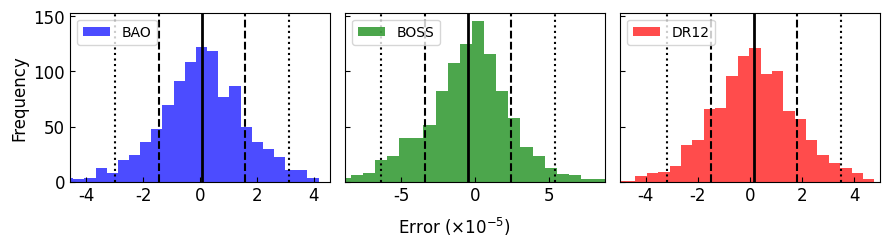

BAO - MAE: 1.1670232197502628e-05, MSE: 2.321596526133618e-10, RMSE: 1.523678656667471e-05
BOSS - MAE: 2.21014615817694e-05, MSE: 8.794953654245319e-10, RMSE: 2.9656286642421037e-05
DR12 - MAE: 1.2874722415290307e-05, MSE: 2.797848341895559e-10, RMSE: 1.6726769899833016e-05


In [12]:
def calculate_errors_and_plot_histograms(datasets, dataset_names):
    n_datasets = len(datasets)
    fig, axes = plt.subplots(1, n_datasets, figsize=(3 * n_datasets, 2.25), sharey=True)

    maes, mses, rmses = [], [], []
    colors = ['blue', 'green', 'red']
    
    for i, ((expected_values, computed_values), name) in enumerate(zip(datasets, dataset_names)):
        errors = expected_values - computed_values

        # Calculate MAE, MSE, and RMSE
        mae = np.mean(np.abs(errors))
        mse = np.mean(errors ** 2)
        rmse = np.sqrt(mse)
        std_dev = np.std(errors)
        maes.append(mae)
        mses.append(mse)
        rmses.append(rmse)

        # Plot histogram of errors
        axes[i].hist(errors, bins=30, alpha=0.7, color=colors[i], label=name)
        axes[i].legend(fontsize='medium', loc='upper left')

        if i == 0:
            axes[i].set_ylabel("Frequency", fontsize='large')

        # Add vertical lines for 1-sigma and 2-sigma
        mean_error = np.mean(errors)
        axes[i].axvline(mean_error, color='k', linestyle='solid', linewidth=2)
        axes[i].axvline(mean_error + std_dev, color='k', linestyle='dashed', linewidth=1.5)
        axes[i].axvline(mean_error - std_dev, color='k', linestyle='dashed', linewidth=1.5)
        axes[i].axvline(mean_error + 2*std_dev, color='k', linestyle='dotted', linewidth=1.5)
        axes[i].axvline(mean_error - 2*std_dev, color='k', linestyle='dotted', linewidth=1.5)

        # Ticks and labels styling
        axes[i].tick_params(direction='in', labelsize='large')
        axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*1e5:.0f}'))
        axes[i].grid(False)
        axes[i].set_xlim(-3*std_dev, 3*std_dev)

    # Shared x-label
    fig.text(0.51, -0.06, r'Error ($\times 10^{-5}$)', ha='center', fontsize='large')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.tight_layout()

    fig.savefig('validation.pdf', bbox_inches='tight')
    
    plt.show()

    return maes, mses, rmses

# Usage for different data sets
datasets = [(np_bao_lkls, tf_bao_lkls), (np_boss_lkls, tf_boss_lkls), (np_dr12_lkls, tf_bdr12_lkls)]
dataset_names = ["BAO", "BOSS", "DR12"]

# Calculate errors and plot histograms
maes, mses, rmses = calculate_errors_and_plot_histograms(datasets, dataset_names)

for name, mae, mse, rmse in zip(dataset_names, maes, mses, rmses):
    print(f"{name} - MAE: {mae}, MSE: {mse}, RMSE: {rmse}")


In [13]:
%%timeit
-tf_bao.loglkl(tf.constant(bao_input[0:1]))

976 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
%%timeit
-tf_boss.loglkl(tf.constant(boss_input[0:1]))

972 µs ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
%%timeit
-tf_dr12.loglkl(tf.constant(dr12_input[0:1]))

986 µs ± 24.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
%%timeit
-bao.loglkl(bao_input[0])

80.5 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%%timeit
-boss.loglkl(boss_input[0])

79.1 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%timeit
-dr12.loglkl(dr12_input[0])

84.1 ms ± 7.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%%timeit
-tf_bao.loglkl(tf.constant(bao_input[0:32]))

2.98 ms ± 49.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%%timeit
-tf_boss.loglkl(tf.constant(boss_input[0:32]))

3.01 ms ± 66.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%%timeit
-tf_dr12.loglkl(tf.constant(dr12_input[0:32]))

3.09 ms ± 24.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%%timeit
for i in range(0, 32):
    -bao.loglkl(bao_input[i])

2.58 s ± 3.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%%timeit
for i in range(0, 32):
    -boss.loglkl(boss_input[i])

2.52 s ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit
for i in range(0, 32):
    -dr12.loglkl(dr12_input[i])

2.54 s ± 5.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
